In [37]:
# !pip install --upgrade scikit-learn xgboost imbalanced-learn

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, precision_recall_curve
from imblearn.over_sampling import SMOTE
from keras.models import Sequential   # Importing Sequential model
from keras.layers import Dense        # Importing Dense layers


In [18]:
# Doing below setting to ensure that we do not see truncated data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Importing Dataset

In [19]:
# Base URL for the dataset
base_url = "https://health.data.ny.gov/resource/q25r-zbis.csv"

# Maximum limit per request
limit = 50000  # Using the maximum allowed limit for SODA 2.0
offset = 0     # Start offset
dfs = []       # List to store chunks

while True:
    # Construct URL with pagination
    url = f"{base_url}?$limit={limit}&$offset={offset}"

    # Read the data
    df = pd.read_csv(url)

    # If no more data, break
    if df.empty:
        break

    # Append to list
    dfs.append(df)

    # Increment offset
    offset += limit

# Concatenate all chunks
full_dataset = pd.concat(dfs, ignore_index=True)

# Save to CSV (optional)
full_dataset.to_csv("rabies.csv", index=False)


In [20]:
df=full_dataset.copy()
df.head()

,received_year,received_month,report_date,county_name,animal_classification,number_of_samples,positive_samples,latitude,longitude,geocode
0,2008,6,06/01/2008,Cattaraugus,Skunk,2,0,42.24942,-78.79884,POINT (-78.79884 42.24942)
1,2010,1,01/01/2010,St. Lawrence,Dog,2,0,44.59563,-75.16923,POINT (-75.16923 44.59563)
2,2017,7,07/01/2017,Orange,Fox,2,2,41.40219,-74.32410,POINT (-74.3241 41.40219)
3,2023,9,09/01/2023,Washington,Fox,1,0,43.26707,-73.58484,POINT (-73.58484 43.26707)
4,2020,4,04/01/2020,Jefferson,Fox,2,1,43.97238,-75.91125,POINT (-75.91125 43.97238)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33895 entries, 0 to 33894
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   received_year          33895 non-null  int64  
 1   received_month         33895 non-null  int64  
 2   report_date            33895 non-null  object 
 3   county_name            33895 non-null  object 
 4   animal_classification  33895 non-null  object 
 5   number_of_samples      33895 non-null  int64  
 6   positive_samples       33895 non-null  int64  
 7   latitude               33895 non-null  float64
 8   longitude              33895 non-null  float64
 9   geocode                33895 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.6+ MB


In [22]:
df.describe()

,received_year,received_month,number_of_samples,positive_samples,latitude,longitude
count,33895.000000,33895.000000,33895.000000,33895.000000,33895.000000,33895.000000
mean,2015.660481,6.589792,3.173595,0.181797,42.667271,-75.545364
std,4.922545,3.174228,8.113104,0.504999,0.900112,1.808321
min,2007.000000,1.000000,1.000000,0.000000,40.746070,-79.501690
25%,2011.000000,4.000000,1.000000,0.000000,42.249420,-76.875560
50%,2016.000000,7.000000,1.000000,0.000000,42.740220,-75.230000
75%,2020.000000,9.000000,3.000000,0.000000,43.061690,-73.794900
max,2024.000000,12.000000,366.000000,9.000000,44.848880,-72.662140


In [23]:
#checking missing value:
print(df.isnull().sum())

received_year            0
received_month           0
report_date              0
county_name              0
animal_classification    0
number_of_samples        0
positive_samples         0
latitude                 0
longitude                0
geocode                  0
dtype: int64


We do not have null values in the dataset.

In [24]:
df.nunique()

,0
received_year,18
received_month,12
report_date,209
county_name,57
animal_classification,10
number_of_samples,122
positive_samples,10
latitude,57
longitude,57
geocode,57


## Checking Duplicates

In [25]:
duplicates = df[df.duplicated()]
print("Duplicate Rows:\n", duplicates)

Duplicate Rows:
 Empty DataFrame
Columns: [received_year, received_month, report_date, county_name, animal_classification, number_of_samples, positive_samples, latitude, longitude, geocode]
Index: []


From above we can observe that there is no duplication

In [26]:
df.describe()

,received_year,received_month,number_of_samples,positive_samples,latitude,longitude
count,33895.000000,33895.000000,33895.000000,33895.000000,33895.000000,33895.000000
mean,2015.660481,6.589792,3.173595,0.181797,42.667271,-75.545364
std,4.922545,3.174228,8.113104,0.504999,0.900112,1.808321
min,2007.000000,1.000000,1.000000,0.000000,40.746070,-79.501690
25%,2011.000000,4.000000,1.000000,0.000000,42.249420,-76.875560
50%,2016.000000,7.000000,1.000000,0.000000,42.740220,-75.230000
75%,2020.000000,9.000000,3.000000,0.000000,43.061690,-73.794900
max,2024.000000,12.000000,366.000000,9.000000,44.848880,-72.662140


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33895 entries, 0 to 33894
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   received_year          33895 non-null  int64  
 1   received_month         33895 non-null  int64  
 2   report_date            33895 non-null  object 
 3   county_name            33895 non-null  object 
 4   animal_classification  33895 non-null  object 
 5   number_of_samples      33895 non-null  int64  
 6   positive_samples       33895 non-null  int64  
 7   latitude               33895 non-null  float64
 8   longitude              33895 non-null  float64
 9   geocode                33895 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.6+ MB


In [28]:
df.columns

Index(['received_year', 'received_month', 'report_date', 'county_name',
       'animal_classification', 'number_of_samples', 'positive_samples',
       'latitude', 'longitude', 'geocode'],
      dtype='object')

In [29]:
df['county_name'].unique()

array(['Cattaraugus', 'St. Lawrence', 'Orange', 'Washington', 'Jefferson',
       'Columbia', 'Genesee', 'Westchester', 'Tompkins', 'Fulton',
       'Rensselaer', 'Albany', 'Clinton', 'Madison', 'Monroe', 'Saratoga',
       'Steuben', 'Ulster', 'Delaware', 'Erie', 'Suffolk', 'Chemung',
       'Chenango', 'Otsego', 'Allegany', 'Onondaga', 'Putnam', 'Lewis',
       'Rockland', 'Seneca', 'Cayuga', 'Ontario', 'Oswego', 'Wayne',
       'Essex', 'Yates', 'Dutchess', 'Schenectady', 'Niagara', 'Herkimer',
       'Nassau', 'Broome', 'Tioga', 'Livingston', 'Orleans', 'Greene',
       'Oneida', 'Cortland', 'Schoharie', 'Schuyler', 'Franklin',
       'Montgomery', 'Sullivan', 'Wyoming', 'Warren', 'Chautauqua',
       'Hamilton'], dtype=object)

In [30]:
region_mapping = {
    'Western NY': ['Cattaraugus', 'Chautauqua', 'Erie', 'Niagara', 'Orleans', 'Genesee', 'Wyoming', 'Allegany'],
    'Finger Lakes': ['Monroe', 'Livingston', 'Ontario', 'Wayne', 'Yates', 'Seneca', 'Steuben', 'Chemung', 'Schuyler', 'Tompkins'],
    'Central NY': ['Onondaga', 'Cayuga', 'Cortland', 'Madison', 'Oswego', 'Oneida', 'Chenango', 'Otsego', 'Broome', 'Tioga', 'Herkimer'],
    'North Country': ['Clinton', 'Franklin', 'Essex', 'Hamilton', 'Lewis', 'St. Lawrence', 'Jefferson'],
    'Capital Region': ['Albany', 'Schenectady', 'Rensselaer', 'Saratoga', 'Warren', 'Washington', 'Fulton', 'Montgomery', 'Schoharie', 'Greene', 'Columbia'],
    'Hudson Valley': ['Westchester', 'Rockland', 'Putnam', 'Orange', 'Dutchess', 'Ulster', 'Sullivan', 'Delaware'],
    'Long Island': ['Nassau', 'Suffolk']
}

Creating regions of counties because creating encodings of all the counties would take a lot of columns.

In [31]:
# Reverse the mapping to create a dictionary of county to region
county_to_region = {county: region for region, counties in region_mapping.items() for county in counties}

# Add a new column 'Geographic Region' to the dataset
df['Geographic Region'] = df['county_name'].map(county_to_region)

# Check the result
display(df[['county_name', 'Geographic Region']].head())

,county_name,Geographic Region
0,Cattaraugus,Western NY
1,St. Lawrence,North Country
2,Orange,Hudson Valley
3,Washington,Capital Region
4,Jefferson,North Country


## Data Understanding

In [32]:
rabies_df = df.copy()

In [33]:
# Apply log transformation to numeric columns (add 1 to handle zeros)
log_columns = ['number_of_samples']  # Add other numeric columns if needed
for col in log_columns:
    rabies_df[f'log_{col}'] = np.log1p(df[col])  # log(x + 1) transformation

# Keep only transformed columns (or modify as needed)
# Option 1: Keep all columns with new transformed versions
# Option 2: Create new DF with only transformed data:
df_log_transformed = rabies_df[['log_number_of_samples']]

# Show before/after comparison
print("Original Values (Head):")
print(rabies_df[['number_of_samples']].head())
print("\nTransformed Values (Head):")
print(df_log_transformed.head())

Original Values (Head):
   number_of_samples
0                  2
1                  2
2                  2
3                  1
4                  2

Transformed Values (Head):
   log_number_of_samples
0               1.098612
1               1.098612
2               1.098612
3               0.693147
4               1.098612


In [34]:
rabies_df.columns

Index(['received_year', 'received_month', 'report_date', 'county_name',
       'animal_classification', 'number_of_samples', 'positive_samples',
       'latitude', 'longitude', 'geocode', 'Geographic Region',
       'log_number_of_samples'],
      dtype='object')

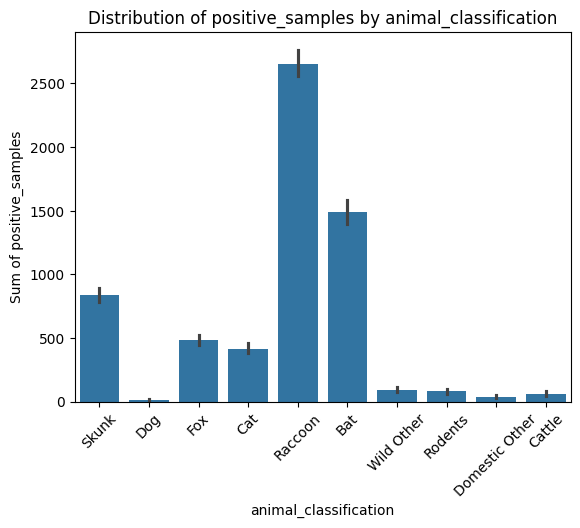

In [35]:
sns.barplot(data=rabies_df, x='animal_classification', y='positive_samples', estimator='sum')
plt.title('Distribution of positive_samples by animal_classification')
plt.xlabel('animal_classification')
plt.ylabel('Sum of positive_samples')
plt.xticks(rotation=45)
plt.show()


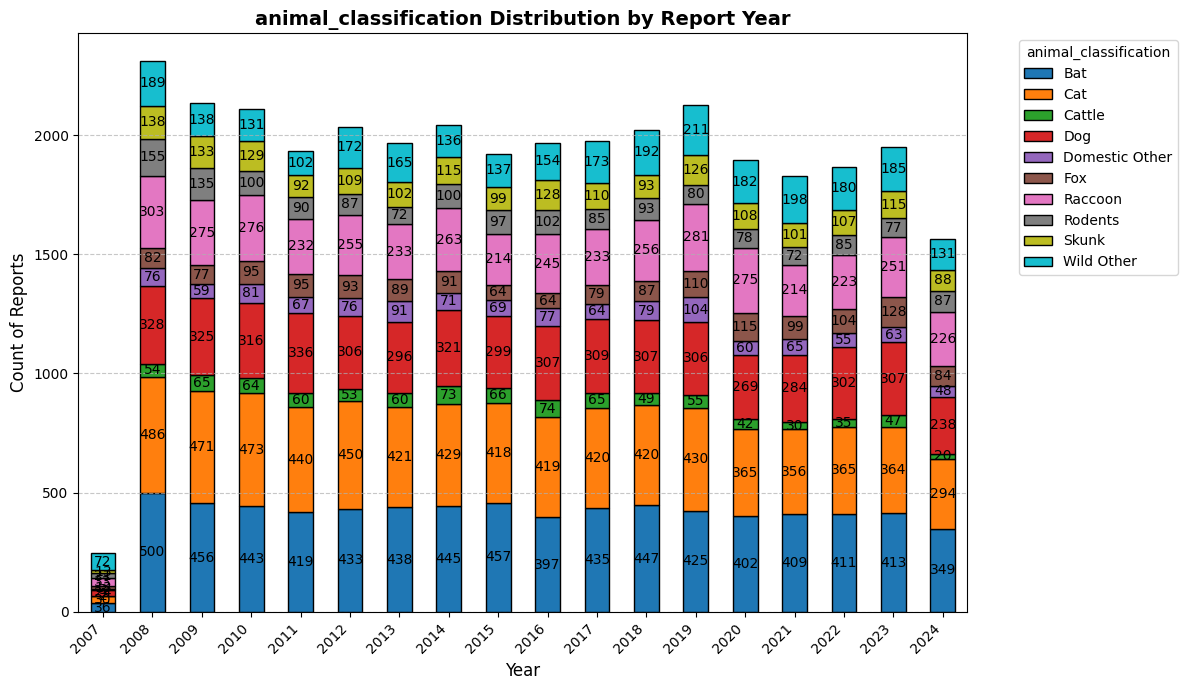

In [36]:
rabies_df['Report Year'] = pd.to_datetime(rabies_df['report_date']).dt.year

# Group and pivot data
animal_year = rabies_df.groupby(['Report Year', 'animal_classification']).size().unstack().fillna(0)

# Set a visually appealing color palette
colors = sns.color_palette("tab10", len(animal_year.columns))

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 7))
animal_year.plot(kind='bar', stacked=True, ax=ax, color=colors, edgecolor='black')

# Improve title and labels
plt.title('animal_classification Distribution by Report Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Reports', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels to bars
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    ha='center', va='center', fontsize=10, color='black')

# Adjust legend
plt.legend(title='animal_classification', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

Geographic Region
Central NY        1147
Capital Region     943
Hudson Valley      858
Finger Lakes       849
Western NY         762
North Country      374
Long Island         53
Name: count, dtype: int64


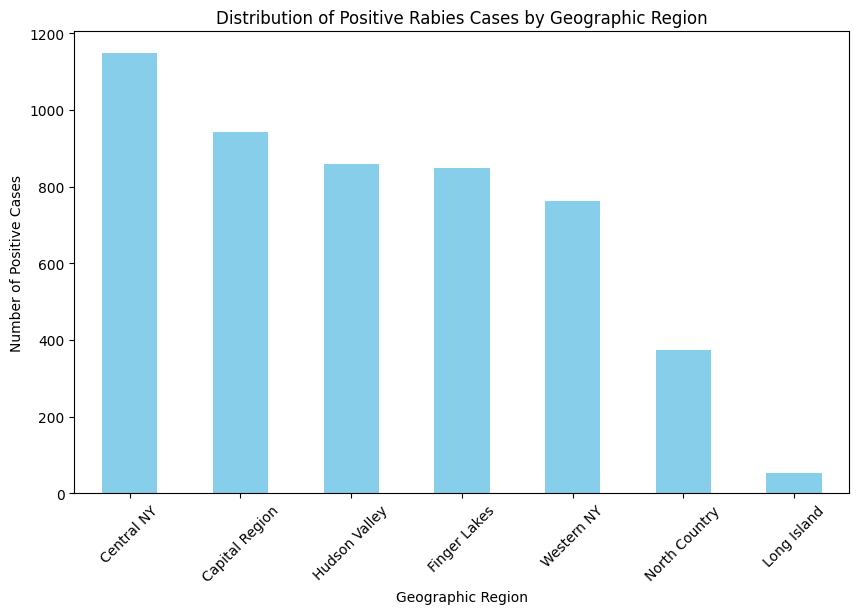

Chi-square p-value: 1.3020324271540673e-55


In [37]:


positive_cases = df[df['positive_samples'] > 0]
region_distribution = positive_cases['Geographic Region'].value_counts()

print(region_distribution)

plt.figure(figsize=(10, 6))
region_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Positive Rabies Cases by Geographic Region')
plt.xlabel('Geographic Region')
plt.ylabel('Number of Positive Cases')
plt.xticks(rotation=45)
plt.show()


# Create a contingency table of regions vs. positive/negative cases
contingency_table = pd.crosstab(df['Geographic Region'], df['positive_samples'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square p-value: {p}")
#H0 -> no relation between region and cases
#H1 -> there is significant relationship

# p-value < 0.05 -> reject null hypothese

Population Density
Rural       3369
Urban        836
Suburban     781
Name: count, dtype: int64


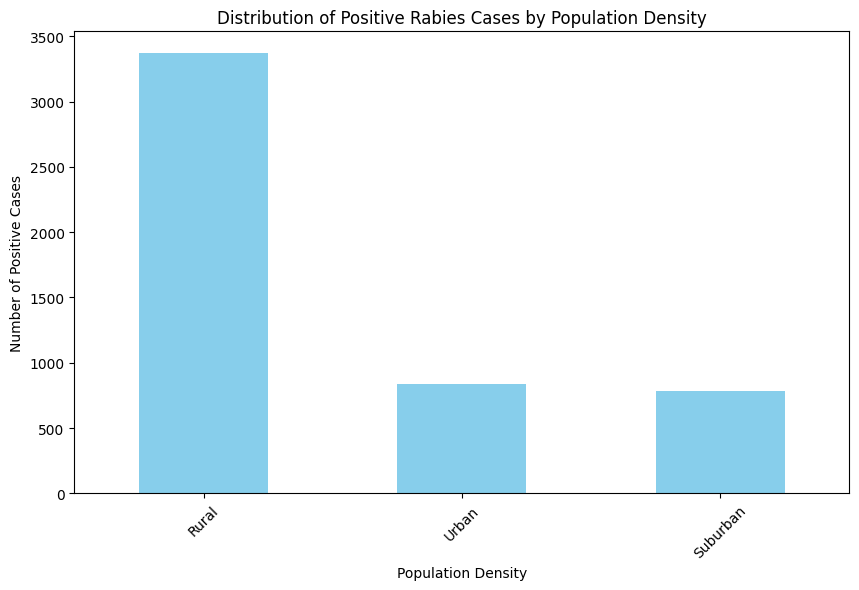

In [38]:
# Define the population density mapping
population_density_mapping = {
    'Urban': ['Erie', 'Monroe', 'Onondaga', 'Albany', 'Nassau', 'Suffolk'],
    'Suburban': ['Westchester', 'Rockland', 'Putnam', 'Orange', 'Dutchess', 'Ulster'],
    # All other counties are classified as "Rural"
}

# Create a reverse mapping of county to population density
county_to_density = {county: density for density, counties in population_density_mapping.items() for county in counties}

# Add a new column 'Population Density' to the dataset
df['Population Density'] = df['county_name'].map(county_to_density)

# For counties not in the mapping, classify them as 'Rural'
df['Population Density'] = df['Population Density'].fillna('Rural')

# Filter positive cases
positive_cases = df[df['positive_samples'] > 0]

# Count the distribution of positive cases by population density
density_distribution = positive_cases['Population Density'].value_counts()

# Print the distribution
print(density_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
density_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Positive Rabies Cases by Population Density')
plt.xlabel('Population Density')
plt.ylabel('Number of Positive Cases')
plt.xticks(rotation=45)
plt.show()

In [39]:
df.columns

Index(['received_year', 'received_month', 'report_date', 'county_name',
       'animal_classification', 'number_of_samples', 'positive_samples',
       'latitude', 'longitude', 'geocode', 'Geographic Region',
       'Population Density'],
      dtype='object')

In [40]:
rabies_df.columns

Index(['received_year', 'received_month', 'report_date', 'county_name',
       'animal_classification', 'number_of_samples', 'positive_samples',
       'latitude', 'longitude', 'geocode', 'Geographic Region',
       'log_number_of_samples', 'Report Year'],
      dtype='object')

In [41]:
# Ensure all text columns are in the same format
rabies_df['county_name'] = rabies_df['county_name'].str.strip().str.lower()
rabies_df['animal_classification'] = rabies_df['animal_classification'].str.strip().str.lower()

In [42]:
# One-Hot Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Geographic Region', 'animal_classification']
encoded_data = encoder.fit_transform(rabies_df[categorical_cols])
encoded_rabies_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

In [43]:
# Drop the original categorical columns from the original dataset
rabies_df = rabies_df.drop(columns=categorical_cols)

# Concatenate the encoded data with the remaining numerical columns
final_rabies_df = pd.concat([rabies_df, encoded_rabies_df], axis=1)

# Display the first few rows of the final dataset
display(final_rabies_df.head())

,received_year,received_month,report_date,county_name,number_of_samples,positive_samples,latitude,longitude,geocode,log_number_of_samples,Report Year,Geographic Region_Central NY,Geographic Region_Finger Lakes,Geographic Region_Hudson Valley,Geographic Region_Long Island,Geographic Region_North Country,Geographic Region_Western NY,animal_classification_cat,animal_classification_cattle,animal_classification_dog,animal_classification_domestic other,animal_classification_fox,animal_classification_raccoon,animal_classification_rodents,animal_classification_skunk,animal_classification_wild other
0,2008,6,06/01/2008,cattaraugus,2,0,42.24942,-78.79884,POINT (-78.79884 42.24942),1.098612,2008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2010,1,01/01/2010,st. lawrence,2,0,44.59563,-75.16923,POINT (-75.16923 44.59563),1.098612,2010,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,7,07/01/2017,orange,2,2,41.40219,-74.32410,POINT (-74.3241 41.40219),1.098612,2017,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2023,9,09/01/2023,washington,1,0,43.26707,-73.58484,POINT (-73.58484 43.26707),0.693147,2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2020,4,04/01/2020,jefferson,2,1,43.97238,-75.91125,POINT (-75.91125 43.97238),1.098612,2020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
final_rabies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33895 entries, 0 to 33894
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   received_year                         33895 non-null  int64  
 1   received_month                        33895 non-null  int64  
 2   report_date                           33895 non-null  object 
 3   county_name                           33895 non-null  object 
 4   number_of_samples                     33895 non-null  int64  
 5   positive_samples                      33895 non-null  int64  
 6   latitude                              33895 non-null  float64
 7   longitude                             33895 non-null  float64
 8   geocode                               33895 non-null  object 
 9   log_number_of_samples                 33895 non-null  float64
 10  Report Year                           33895 non-null  int32  
 11  Geographic Regi

## Feature Engineering

In [46]:
# Drop unnecessary columns which are duplicated
data = final_rabies_df.drop(columns=['geocode', 'report_date', 'county_name'])
# Verify the remaining columns
print(data.columns)

Index(['received_year', 'received_month', 'number_of_samples',
       'positive_samples', 'latitude', 'longitude', 'log_number_of_samples',
       'Report Year', 'Geographic Region_Central NY',
       'Geographic Region_Finger Lakes', 'Geographic Region_Hudson Valley',
       'Geographic Region_Long Island', 'Geographic Region_North Country',
       'Geographic Region_Western NY', 'animal_classification_cat',
       'animal_classification_cattle', 'animal_classification_dog',
       'animal_classification_domestic other', 'animal_classification_fox',
       'animal_classification_raccoon', 'animal_classification_rodents',
       'animal_classification_skunk', 'animal_classification_wild other'],
      dtype='object')


In [47]:
# Aggregate positive cases by year and month
timeline_data = data.groupby(['received_year', 'received_month'])['positive_samples'].sum().reset_index()

# Create a datetime column for plotting
timeline_data['Date'] = pd.to_datetime(
    timeline_data['received_year'].astype(str) + '-' + timeline_data['received_month'].astype(str)
)

# Sort by date
timeline_data = timeline_data.sort_values('Date')

print(timeline_data.head())

   received_year  received_month  positive_samples       Date
0           2007               5                 3 2007-05-01
1           2007               6                 8 2007-06-01
2           2007               7                13 2007-07-01
3           2007               8                15 2007-08-01
4           2007               9                 8 2007-09-01


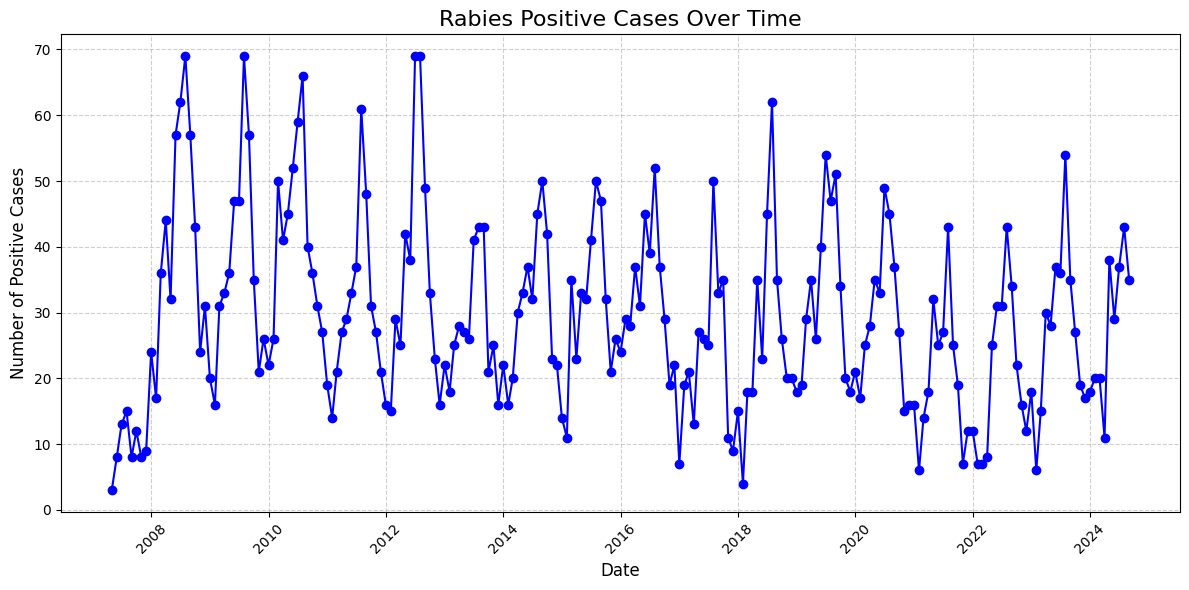

In [48]:
# Plot timeline of positive cases
plt.figure(figsize=(12, 6))
plt.plot(timeline_data['Date'], timeline_data['positive_samples'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Rabies Positive Cases Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Positive Cases', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

In [49]:


# List of all animal_classification columns
animal_columns = [
    'animal_classification_skunk', 'animal_classification_raccoon',
    'animal_classification_fox', 'animal_classification_cat',
    'animal_classification_dog', 'animal_classification_cattle',
    'animal_classification_domestic other', 'animal_classification_rodents',
    'animal_classification_wild other'
]

# Aggregate positive cases by animal type and timeline
animal_timeline = data.groupby(
    ['received_year', 'received_month'] + animal_columns
)['positive_samples'].sum().reset_index()

# Melt animal columns for faceting
animal_timeline = animal_timeline.melt(
    id_vars=['received_year', 'received_month', 'positive_samples'],
    value_vars=animal_columns,
    var_name='Animal Type',
    value_name='Is Present'
)

# Filter for rows where the animal is present
animal_timeline = animal_timeline[animal_timeline['Is Present'] == 1]

# Create datetime column
animal_timeline['Date'] = pd.to_datetime(
    animal_timeline['received_year'].astype(str) + '-' + animal_timeline['received_month'].astype(str)
)

# Sort by date
animal_timeline = animal_timeline.sort_values('Date')

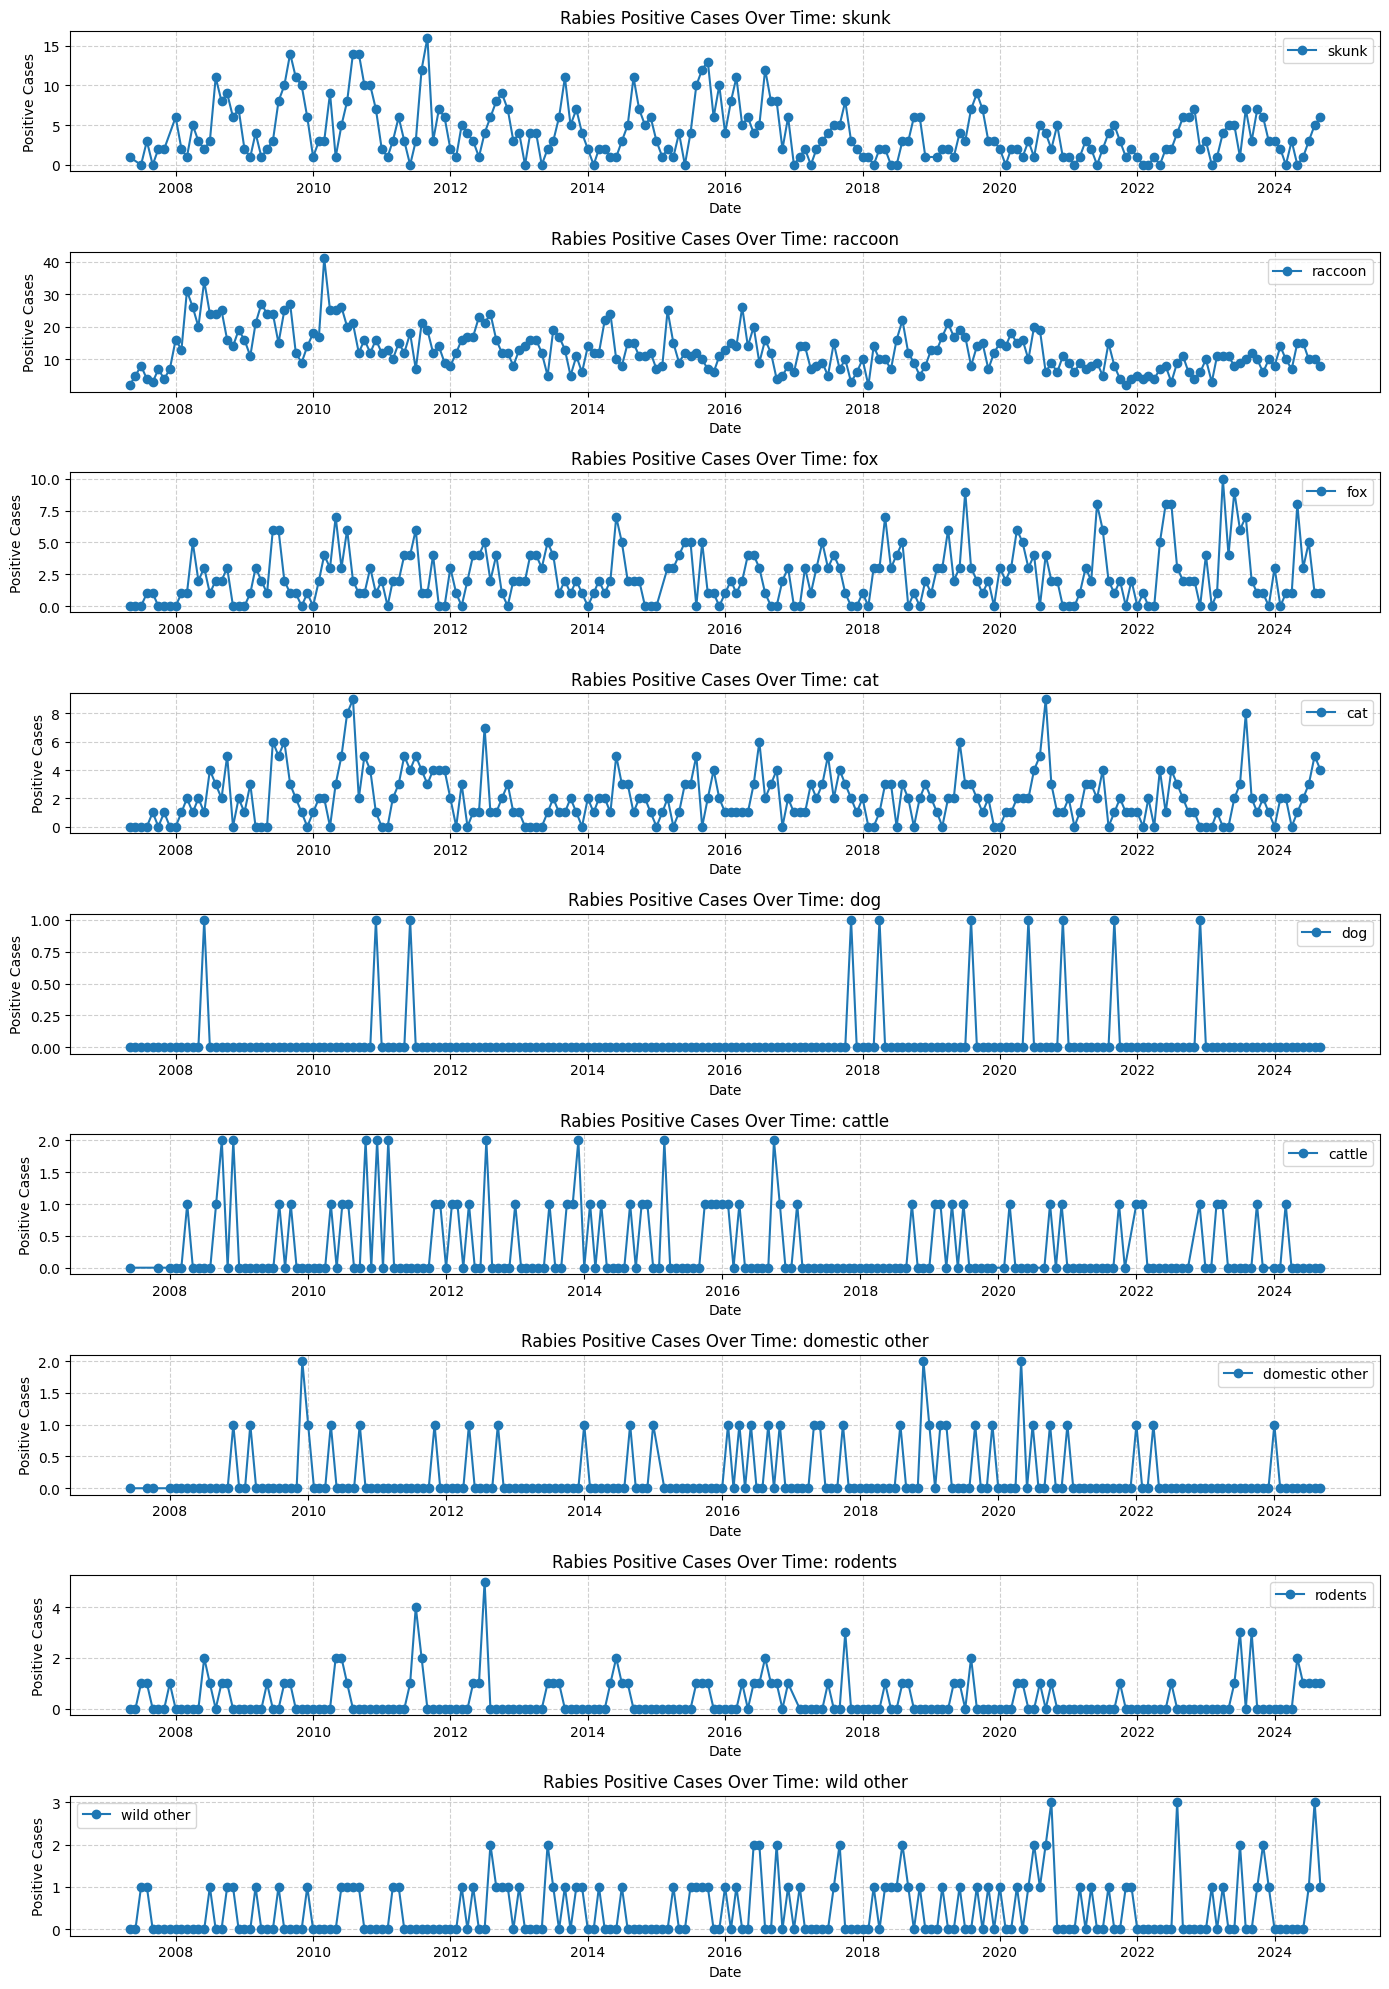

In [50]:
# Plot faceted timeline for all animal types
plt.figure(figsize=(14, 20))  # Adjust figure size for more subplots

# Loop through each animal type and create a subplot
for i, animal in enumerate(animal_columns, 1):
    plt.subplot(len(animal_columns), 1, i)
    subset = animal_timeline[animal_timeline['Animal Type'] == animal]
    plt.plot(subset['Date'], subset['positive_samples'], marker='o', linestyle='-', label=animal.split('_')[-1])
    plt.title(f'Rabies Positive Cases Over Time: {animal.split("_")[-1]}', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Positive Cases', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

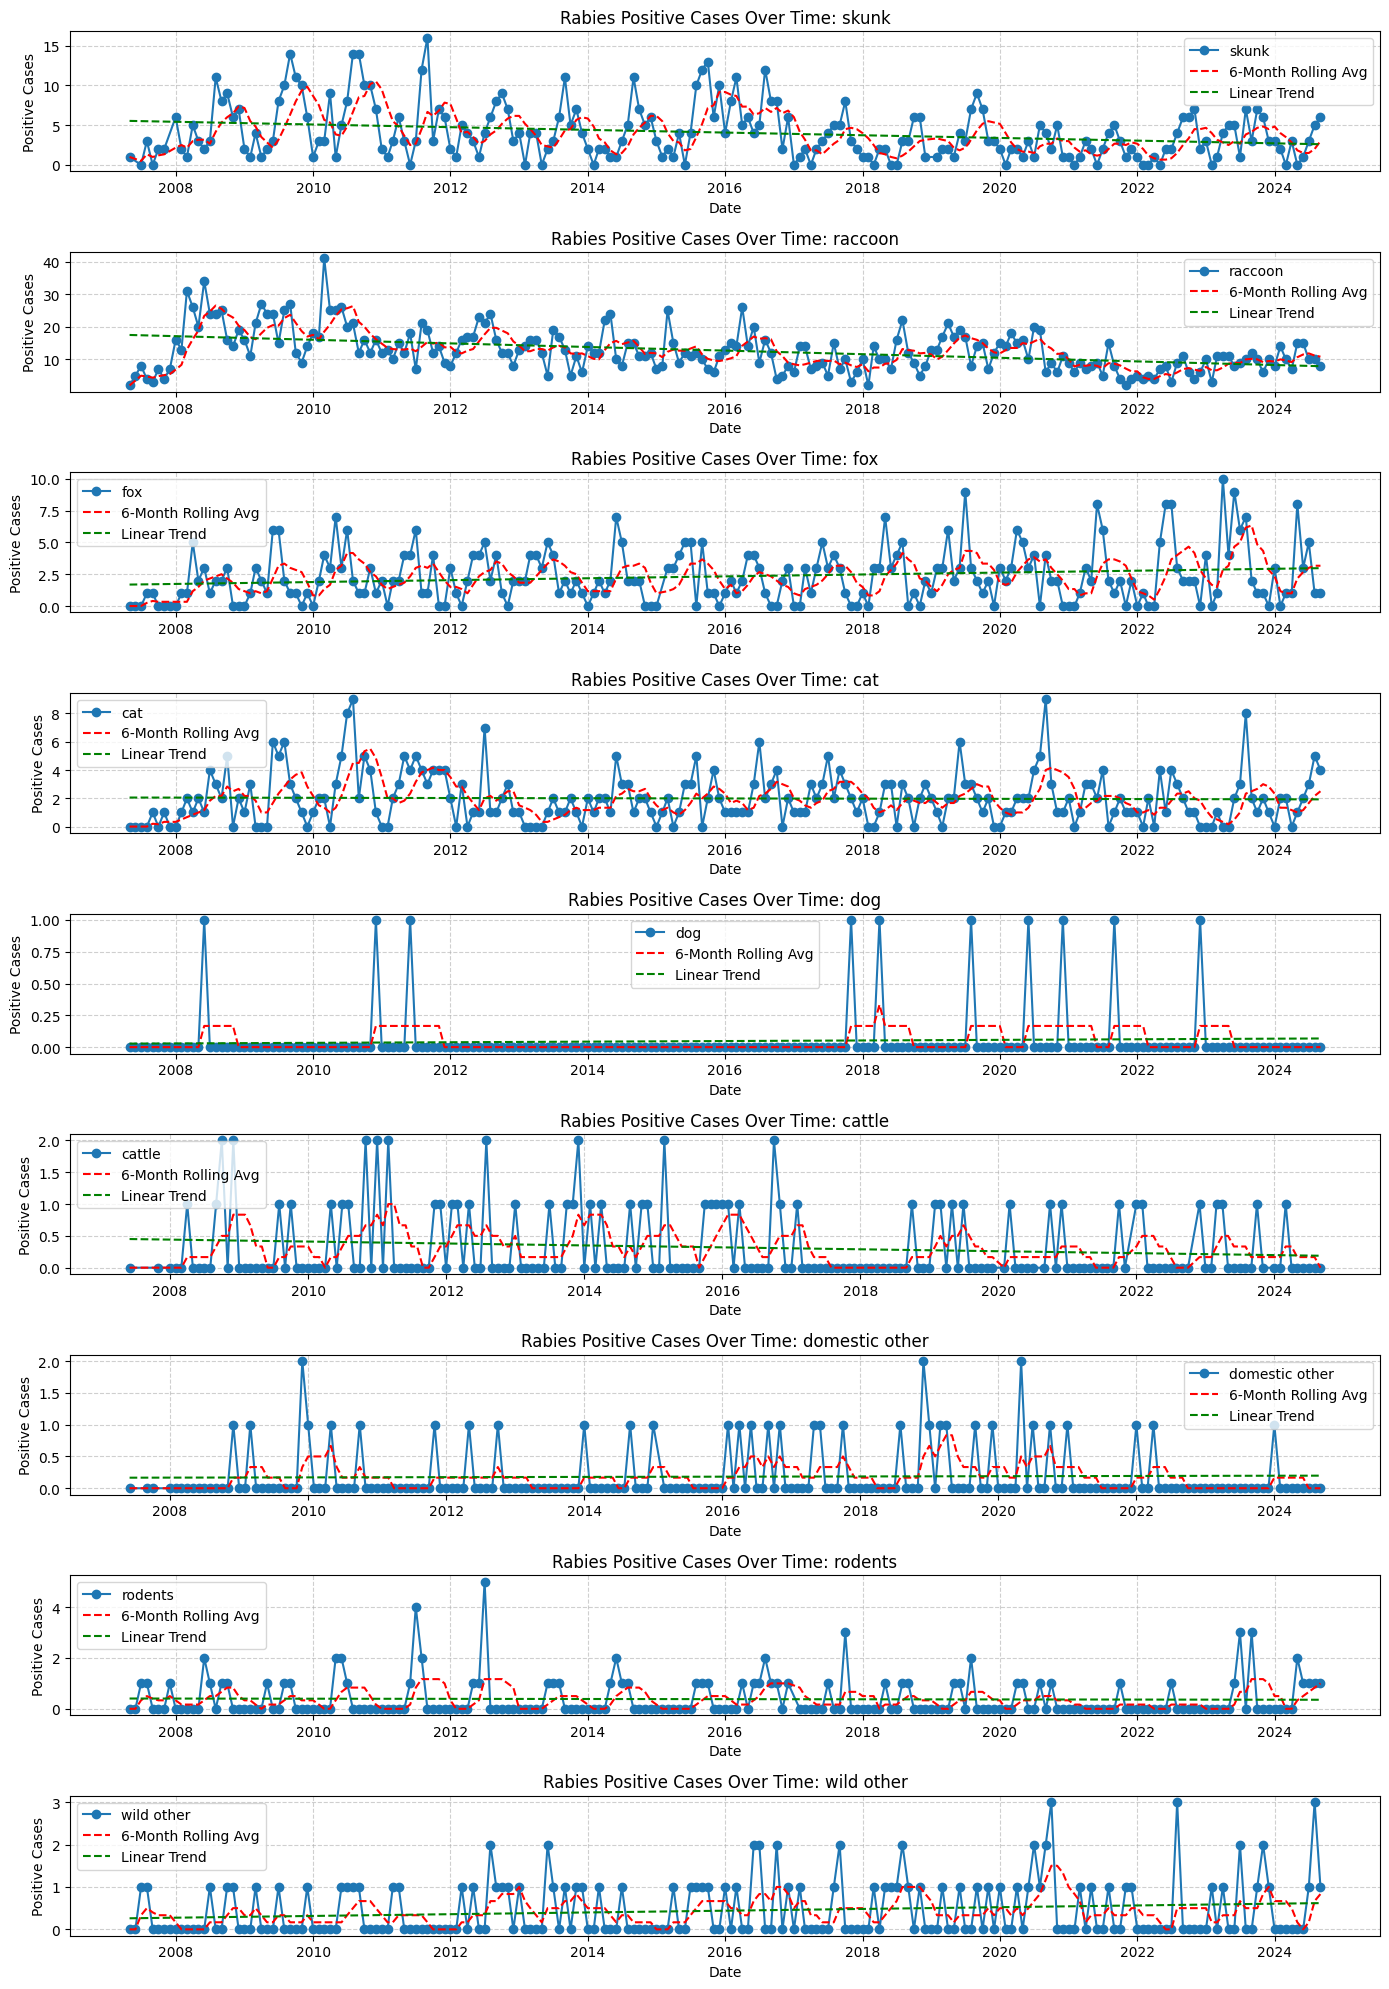

In [51]:
# Plot faceted timeline with trend lines
plt.figure(figsize=(14, 20))

for i, animal in enumerate(animal_columns, 1):
    plt.subplot(len(animal_columns), 1, i)
    subset = animal_timeline[animal_timeline['Animal Type'] == animal]

    # Plot monthly cases
    plt.plot(subset['Date'], subset['positive_samples'], marker='o', linestyle='-', label=animal.split('_')[-1])

    # Add rolling average trend line
    subset['Rolling_Avg'] = subset['positive_samples'].rolling(window=6, min_periods=1).mean()
    plt.plot(subset['Date'], subset['Rolling_Avg'], linestyle='--', color='r', label='6-Month Rolling Avg')

    # Add linear regression trend line
    subset['Date_num'] = (subset['Date'] - subset['Date'].min()).dt.days
    X = subset[['Date_num']]
    y = subset['positive_samples']
    reg = LinearRegression().fit(X, y)
    subset['Trend_Line'] = reg.predict(X)
    plt.plot(subset['Date'], subset['Trend_Line'], linestyle='--', color='g', label='Linear Trend')

    # Add labels and title
    plt.title(f'Rabies Positive Cases Over Time: {animal.split("_")[-1]}', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Positive Cases', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [52]:
data.columns

Index(['received_year', 'received_month', 'number_of_samples',
       'positive_samples', 'latitude', 'longitude', 'log_number_of_samples',
       'Report Year', 'Geographic Region_Central NY',
       'Geographic Region_Finger Lakes', 'Geographic Region_Hudson Valley',
       'Geographic Region_Long Island', 'Geographic Region_North Country',
       'Geographic Region_Western NY', 'animal_classification_cat',
       'animal_classification_cattle', 'animal_classification_dog',
       'animal_classification_domestic other', 'animal_classification_fox',
       'animal_classification_raccoon', 'animal_classification_rodents',
       'animal_classification_skunk', 'animal_classification_wild other'],
      dtype='object')

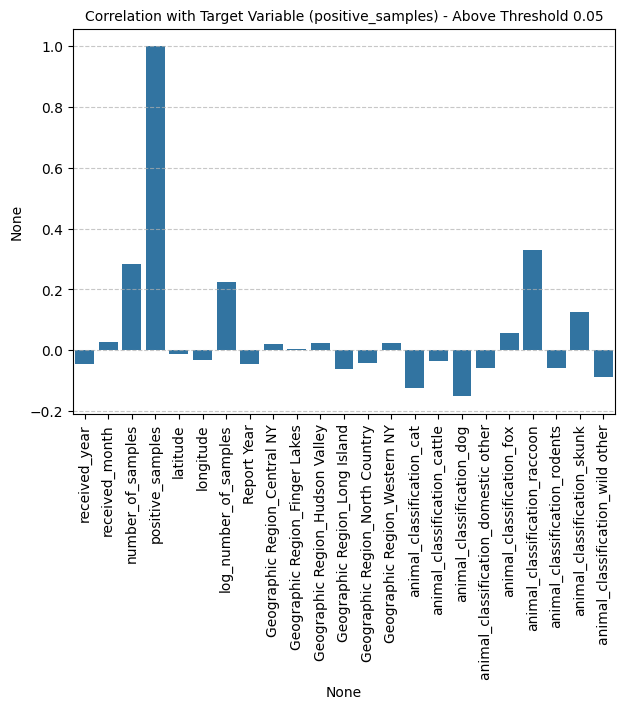

In [53]:
# Above columns correlation with target variable

correlation_values = data.corrwith(data['positive_samples'])

threshold = 0
columns_above_threshold = correlation_values[abs(correlation_values) > threshold].index


plt.figure(figsize=(7, 5))
plt.title('Correlation with Target Variable (positive_samples) - Above Threshold 0.05', fontsize=10)
sns.barplot(x=columns_above_threshold, y=correlation_values[columns_above_threshold])
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
data.columns

Index(['received_year', 'received_month', 'number_of_samples',
       'positive_samples', 'latitude', 'longitude', 'log_number_of_samples',
       'Report Year', 'Geographic Region_Central NY',
       'Geographic Region_Finger Lakes', 'Geographic Region_Hudson Valley',
       'Geographic Region_Long Island', 'Geographic Region_North Country',
       'Geographic Region_Western NY', 'animal_classification_cat',
       'animal_classification_cattle', 'animal_classification_dog',
       'animal_classification_domestic other', 'animal_classification_fox',
       'animal_classification_raccoon', 'animal_classification_rodents',
       'animal_classification_skunk', 'animal_classification_wild other',
       'skunk_westny', 'raccoon_hudson', 'fox_north', 'cat_longisland',
       'dog_centralny'],
      dtype='object')

In [56]:
# Create interaction features
data['skunk_westny'] = data['animal_classification_skunk'] * data['Geographic Region_Western NY']
data['raccoon_hudson'] = data['animal_classification_raccoon'] * data['Geographic Region_Hudson Valley']
data['fox_north'] = data['animal_classification_fox'] * data['Geographic Region_North Country']
data['cat_longisland'] = data['animal_classification_cat'] * data['Geographic Region_Long Island']
data['dog_centralny'] = data['animal_classification_dog'] * data['Geographic Region_Central NY']

# Create temporal-spatial interactions
# data['year_latitude'] = data['received_year'] * data['Latitude Center Point']
# data['month_longitude'] = data['received_month'] * data['Longitude Center Point']

# Create sample-based interactions
data['samples_skunk'] = data['number_of_samples'] * data['animal_classification_skunk']
data['samples_raccoon'] = data['number_of_samples'] * data['animal_classification_raccoon']
data['samples_fox'] = data['number_of_samples'] * data['animal_classification_fox']


In [57]:
data.columns

Index(['received_year', 'received_month', 'number_of_samples',
       'positive_samples', 'latitude', 'longitude', 'log_number_of_samples',
       'Report Year', 'Geographic Region_Central NY',
       'Geographic Region_Finger Lakes', 'Geographic Region_Hudson Valley',
       'Geographic Region_Long Island', 'Geographic Region_North Country',
       'Geographic Region_Western NY', 'animal_classification_cat',
       'animal_classification_cattle', 'animal_classification_dog',
       'animal_classification_domestic other', 'animal_classification_fox',
       'animal_classification_raccoon', 'animal_classification_rodents',
       'animal_classification_skunk', 'animal_classification_wild other',
       'skunk_westny', 'raccoon_hudson', 'fox_north', 'cat_longisland',
       'dog_centralny', 'samples_skunk', 'samples_raccoon', 'samples_fox'],
      dtype='object')

Lagged Positivity Ratio(6months)
No Data Leakage: The shift(1) ensures the current row’s target isn’t used in the calculation.

Handling First 6 Months: The min_periods=1 ensures the calculation starts with the first available data point.

Grouping: The calculation is done separately for each animal-region combination to capture localized trends.

In [58]:
# Sort data by year and month
data = data.sort_values(['received_year', 'received_month'])

# Calculate lagged positivity ratio
data['lagged_positivity_ratio'] = data.groupby(
    ['animal_classification_skunk', 'animal_classification_raccoon',
     'animal_classification_fox', 'Geographic Region_Western NY',
     'Geographic Region_Hudson Valley', 'Geographic Region_North Country']
)['positive_samples'].transform(
    lambda x: x.rolling(window=6, min_periods=1).sum() /
              x.rolling(window=6, min_periods=1).count().replace(0, 1)
).shift(1)  # Shift by 1 to avoid data leakage

# Fill NaN values with 0 (or use a global average if preferred)
data['lagged_positivity_ratio'] = data['lagged_positivity_ratio'].fillna(0)

# Verify the result
display(data[['received_year', 'received_month', 'positive_samples', 'lagged_positivity_ratio']].head(10))

,received_year,received_month,positive_samples,lagged_positivity_ratio
1169,2007,5,0,0.0
2618,2007,5,0,0.0
3841,2007,5,0,0.0
4751,2007,5,0,0.0
7453,2007,5,0,0.0
14156,2007,5,1,0.0
14670,2007,5,0,0.5
16472,2007,5,0,0.0
21596,2007,5,0,0.0
22070,2007,5,0,0.0


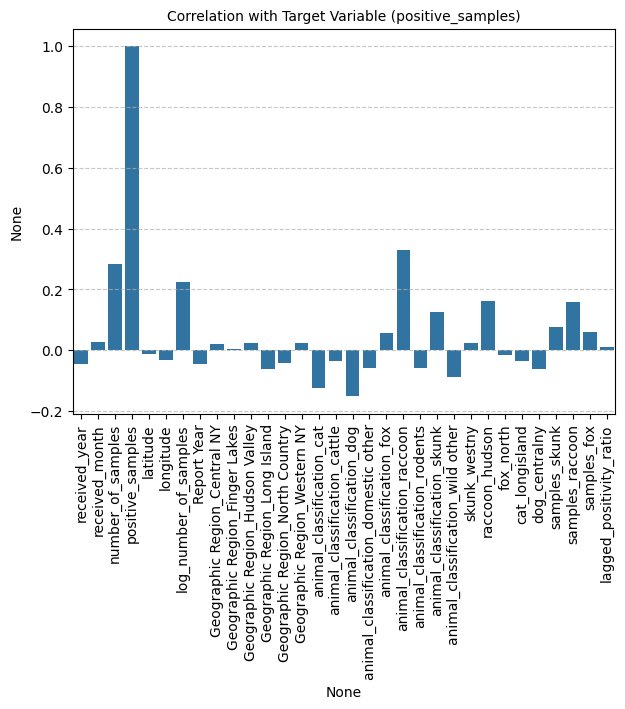

In [59]:
# Above columns correlation with target variable

correlation_values = data.corrwith(data['positive_samples'])

threshold = 0
columns_above_threshold = correlation_values[abs(correlation_values) > threshold].index


plt.figure(figsize=(7, 5))
plt.title('Correlation with Target Variable (positive_samples)', fontsize=10)
sns.barplot(x=columns_above_threshold, y=correlation_values[columns_above_threshold])
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [60]:
#applying lasso regression


# Assuming 'data' is your DataFrame
# Create binary target
data['is_positive'] = (data['positive_samples'] > 0).astype(int)

# Define features and target
X = data.drop(columns=['is_positive', 'positive_samples'])  # Features
y = data['is_positive']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LassoCV to find the best alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Print the best alpha
print(f"Best alpha (regularization strength): {lasso.alpha_}")

# Get feature coefficients
feature_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

# Sort features by absolute coefficient value (most important to least important)
feature_coef['Absolute_Coefficient'] = np.abs(feature_coef['Coefficient'])
feature_coef = feature_coef.sort_values('Absolute_Coefficient', ascending=False)

# Apply threshold of 0.01 and select features
threshold = 0.01
selected_features = feature_coef[feature_coef['Absolute_Coefficient'] > threshold]

# Print sorted selected features
print("\nSelected Features (Absolute Coefficient > 0.01):")
print(selected_features[['Feature', 'Coefficient', 'Absolute_Coefficient']])

# Extract column names of selected features
selected_feature_names = selected_features['Feature'].tolist()
print("\nSelected Feature Names:")
print(selected_feature_names)

Best alpha (regularization strength): 0.00012062645345321724

Selected Features (Absolute Coefficient > 0.01):
                                 Feature  Coefficient  Absolute_Coefficient
18         animal_classification_raccoon     0.131834              0.131834
20           animal_classification_skunk     0.077641              0.077641
17             animal_classification_fox     0.040846              0.040846
28                       samples_raccoon    -0.039881              0.039881
5                  log_number_of_samples     0.038653              0.038653
10         Geographic Region_Long Island    -0.036768              0.036768
2                      number_of_samples     0.033429              0.033429
15             animal_classification_dog    -0.032079              0.032079
13             animal_classification_cat    -0.024158              0.024158
3                               latitude    -0.020069              0.020069
11       Geographic Region_North Country    -0.019291

In [61]:
selected_feature_names.remove('number_of_samples')
selected_feature_names.append('positive_samples')

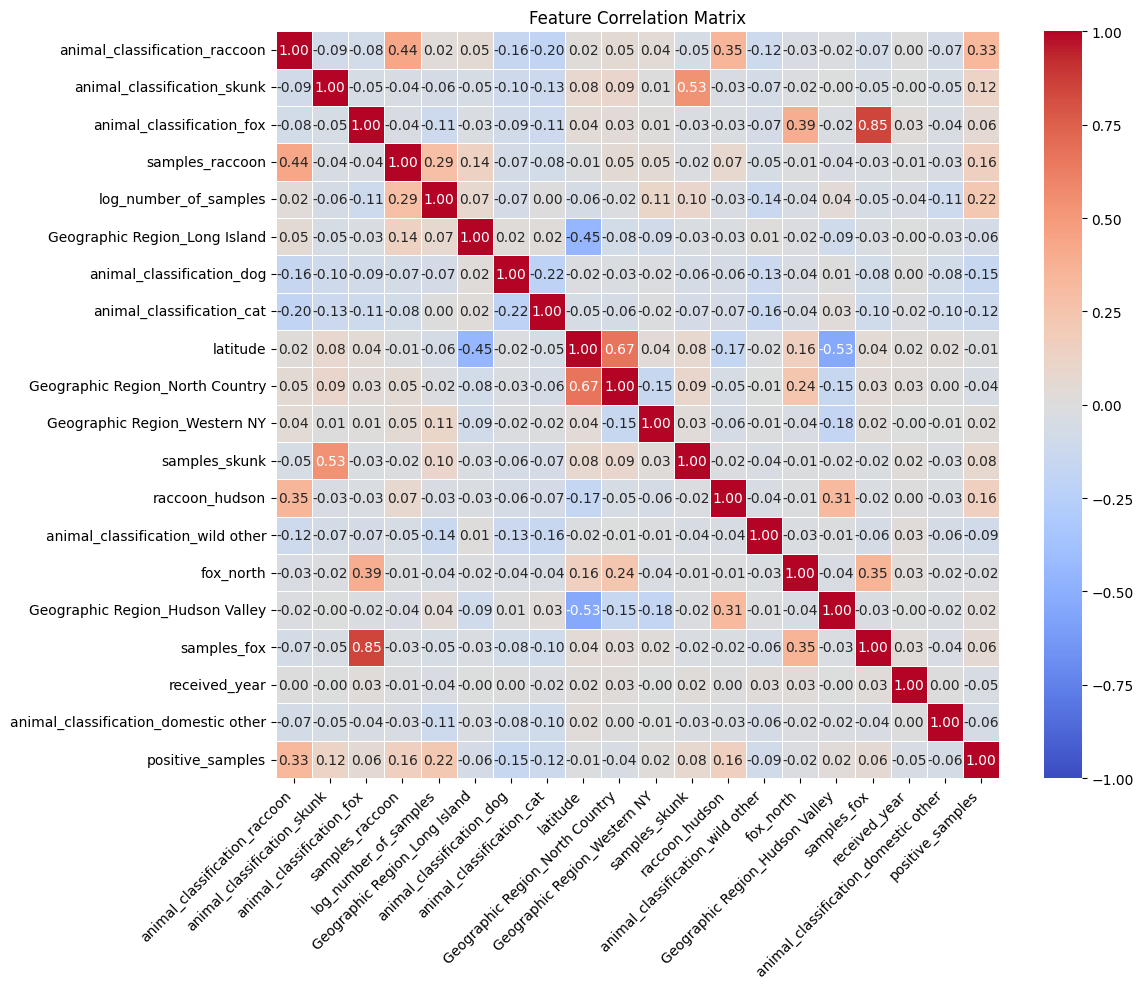

In [62]:
# Compute correlation matrix for selected features
corr_matrix = data[selected_feature_names].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,        # Show correlation values
    cmap='coolwarm',   # Red-blue color scheme
    fmt=".2f",         # 2 decimal places
    vmin=-1, vmax=1,   # Fix color scale between -1 and 1
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [63]:
selected_feature_names.remove('samples_fox')

In [64]:
final_df = data[selected_feature_names]

In [65]:
final_df.columns

Index(['animal_classification_raccoon', 'animal_classification_skunk',
       'animal_classification_fox', 'samples_raccoon', 'log_number_of_samples',
       'Geographic Region_Long Island', 'animal_classification_dog',
       'animal_classification_cat', 'latitude',
       'Geographic Region_North Country', 'Geographic Region_Western NY',
       'samples_skunk', 'raccoon_hudson', 'animal_classification_wild other',
       'fox_north', 'Geographic Region_Hudson Valley', 'received_year',
       'animal_classification_domestic other', 'positive_samples'],
      dtype='object')

Modelling

In [66]:
model_df = final_df.copy()

Train Test Validation Split

In [67]:
model_df['is_positive'] = (model_df['positive_samples'] > 0).astype(int)

# Define features and target
X = model_df.drop(columns=['is_positive', 'positive_samples'])  # Features
y = model_df['is_positive']  # Target

# First, split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, split the training set into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


# Scale features (important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [68]:
X_train.shape, X_test.shape

((21692, 18), (6779, 18))

In [69]:
y_train.shape, y_test.shape

((21692,), (6779,))

#LOGISTIC REGRESSION

In [70]:

# Initialize and train logistic regression with class balancing
log_reg = LogisticRegression(
    class_weight='balanced',  # Handles class imbalance
    solver='lbfgs',  # Good default solver
    max_iter=1000,   # Ensure convergence
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

# Make predictions on validation and test sets
y_validation_pred = log_reg.predict(X_validation_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get predicted probabilities for the validation and test sets
y_validation_prob = log_reg.predict_proba(X_validation_scaled)[:, 1]  # Probabilities for class 1
y_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute log loss
validation_loss = log_loss(y_validation, y_validation_prob)
test_loss = log_loss(y_test, y_test_prob)

# Evaluate model on validation set
print("Validation Performance:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print("\nClassification Report:")
print(classification_report(y_validation, y_validation_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred))
# Print loss values
print("\nValidation Log Loss:", validation_loss)

# Evaluate model on test set
print("\nTest Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
# Print loss values
print("Test Log Loss:", test_loss)


Validation Performance:
Accuracy: 0.7874262536873157

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      4626
           1       0.39      0.81      0.53       798

    accuracy                           0.79      5424
   macro avg       0.68      0.80      0.70      5424
weighted avg       0.88      0.79      0.81      5424


Confusion Matrix:
[[3625 1001]
 [ 152  646]]

Validation Log Loss: 0.47800357347204714

Test Performance:
Accuracy: 0.7824162855878448

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      5782
           1       0.38      0.80      0.52       997

    accuracy                           0.78      6779
   macro avg       0.67      0.79      0.69      6779
weighted avg       0.87      0.78      0.81      6779


Confusion Matrix:
[[4505 1277]
 [ 198  799]]
Test Log Loss: 0.47529788400476924




#### This means the model did not overfit since the validation and test accuracy is close and it is able to generalize

#SVM

In [71]:
svm_model = SVC(
    class_weight='balanced',  # Handles class imbalance
    probability=True,         # Required for probability estimates (log loss)
    random_state=42           # Reproducibility
)

# Train on scaled training data
svm_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets (using scaled data)
y_val_pred = svm_model.predict(X_validation_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Get probabilities for log loss
y_val_prob = svm_model.predict_proba(X_validation_scaled)[:, 1]
y_test_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate (add these metrics to your existing code)
print("Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_validation, y_val_pred):.4f}")
print(f"Log Loss: {log_loss(y_validation, y_val_prob):.4f}")
print(classification_report(y_validation, y_val_pred))
print(confusion_matrix(y_validation, y_val_pred))

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_svm):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_prob):.4f}")
print(classification_report(y_test, y_test_pred_svm))
print(confusion_matrix(y_test, y_test_pred_svm))

Validation Metrics:
Accuracy: 0.8114
Log Loss: 0.3028
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      4626
           1       0.42      0.80      0.55       798

    accuracy                           0.81      5424
   macro avg       0.69      0.80      0.72      5424
weighted avg       0.88      0.81      0.83      5424

[[3766  860]
 [ 163  635]]

Test Metrics:
Accuracy: 0.8097
Log Loss: 0.4753
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5782
           1       0.42      0.79      0.55       997

    accuracy                           0.81      6779
   macro avg       0.69      0.80      0.71      6779
weighted avg       0.88      0.81      0.83      6779

[[4701 1081]
 [ 209  788]]


#XG BOOST

In [72]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate class weight for imbalance handling
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Configure XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    n_estimators=1000,
    eval_metric='aucpr',  # Optimize for precision-recall curve
    early_stopping_rounds=20,
    random_state=42
)

# Train model
model.fit(
    X_train, y_train,
    eval_set=[(X_validation, y_validation)],
    verbose=50
)

# Optimize threshold using F1-score
y_validation_probs = model.predict_proba(X_validation)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_validation, y_validation_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

# Final predictions
y_validation_pred = (y_validation_probs >= best_threshold).astype(int)
y_test_probs_xg = model.predict_proba(X_test)[:, 1]
y_test_pred_xg = (y_test_probs_xg >= best_threshold).astype(int)

# Compute log loss
validation_loss = log_loss(y_validation, y_validation_probs)
test_loss = log_loss(y_test, y_test_probs_xg)

# Validation set metrics
print(f"Optimal Threshold: {best_threshold:.3f}")
print("\nValidation Performance:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print("\nClassification Report:")
print(classification_report(y_validation, y_validation_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred))
print("\nValidation Log Loss:", validation_loss)

# Test set metrics
print("\nTest Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_xg))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_xg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xg))
print("\nTest Log Loss:", test_loss)


[0]	validation_0-aucpr:0.42158
[50]	validation_0-aucpr:0.55037
[100]	validation_0-aucpr:0.55961
[150]	validation_0-aucpr:0.56426
[166]	validation_0-aucpr:0.56268
Optimal Threshold: 0.684

Validation Performance:
Accuracy: 0.8560103244837758

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      4626
           1       0.51      0.69      0.59       798

    accuracy                           0.86      5424
   macro avg       0.73      0.79      0.75      5424
weighted avg       0.88      0.86      0.86      5424


Confusion Matrix:
[[4092  534]
 [ 247  551]]

Validation Log Loss: 0.4448884030714951

Test Performance:
Accuracy: 0.8576486207405222

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5782
           1       0.51      0.69      0.59       997

    accuracy                           0.86      6779
   macro avg       0.73      0.

#Neural Network

In [74]:
def neural_network_adam_implementation(X_train, X_validation, X_test, y_train, y_validation, y_test):
    # Declaring the model
    model = Sequential([
        Dense(units=10, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(units=20, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    # Compiling the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Training the model with validation set & storing history
    history = model.fit(X_train, y_train, epochs=100, batch_size=15, validation_data=(X_validation, y_validation))

    # Extract validation loss after training
    validation_loss = history.history['val_loss'][-1]  # Last recorded validation loss

    # Evaluating the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # print("\nTest Set Performance:")
    # print("Loss =", test_loss)
    # print("Accuracy =", test_accuracy)

    # Predicting on validation and test sets
    y_validation_pred_probs = model.predict(X_validation)
    y_test_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels (Threshold = 0.5)
    y_validation_pred = (y_validation_pred_probs > 0.5).astype(int).flatten()
    y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

    # Compute log loss for validation and test sets
    validation_log_loss = log_loss(y_validation, y_validation_pred_probs)
    test_log_loss = log_loss(y_test, y_test_pred_probs)

    # Print Validation Performance
    print("\nValidation Performance:")
    print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
    print("\nClassification Report:\n", classification_report(y_validation, y_validation_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_validation, y_validation_pred))
    print("\nValidation Log Loss:", validation_log_loss)

    # Print Test Performance
    print("\nTest Performance:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("\nTest Log Loss:", test_log_loss)

# Example usage:
# Assuming X_train_scaled, X_validation_scaled, X_test_scaled, y_train, y_validation, y_test are defined
neural_network_adam_implementation(X_train_scaled, X_validation_scaled, X_test_scaled, y_train, y_validation, y_test)


Epoch 1/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7622 - loss: 0.4470 - val_accuracy: 0.8649 - val_loss: 0.2994
Epoch 2/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8670 - loss: 0.2994 - val_accuracy: 0.8665 - val_loss: 0.2954
Epoch 3/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8658 - loss: 0.3028 - val_accuracy: 0.8739 - val_loss: 0.2937
Epoch 4/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8689 - loss: 0.2968 - val_accuracy: 0.8761 - val_loss: 0.2944
Epoch 5/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8693 - loss: 0.2948 - val_accuracy: 0.8722 - val_loss: 0.2943
Epoch 6/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8695 - loss: 0.2960 - val_accuracy: 0.8757 - val_loss: 0.2927
Epoch 7/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8722 - loss: 0.2929 - val_accuracy: 0.8722 - val_loss: 0.2933
Epoch 8/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8736 - loss: 0

In [75]:
from prettytable import PrettyTable

# Define model names
models = ["Logistic Regression", "SVM", "XGBoost", "Neural Network"]

# Accuracy Scores
accuracy_scores = [0.781, 0.813, 0.846, 0.872]

# Log Loss Values
log_loss_values = [0.4755, 0.6327, 0.4448, 0.2883]

# Precision, Recall, and F1-score for Class 1
precision_scores = [0.38, 0.43, 0.48, 0.59]
recall_scores = [0.80, 0.79, 0.71, 0.43]
f1_scores = [0.52, 0.56, 0.58, 0.50]

# Function to print a pretty table
def print_pretty_table(headers, data):
    table = PrettyTable(headers)
    for row in zip(*data):
        table.add_row(row)
    print(table)

# Print each table separately

# Accuracy Table
print("Model Comparison (Accuracy)")
print_pretty_table(["Model", "Accuracy"], [models, accuracy_scores])
print("\n")

# Log Loss Table
print("Model Comparison (Log Loss)")
print_pretty_table(["Model", "Log Loss"], [models, log_loss_values])
print("\n")

# Precision Table
print("Model Comparison (Precision for Class 1)")
print_pretty_table(["Model", "Precision (Class 1)"], [models, precision_scores])
print("\n")

# Recall Table
print("Model Comparison (Recall for Class 1)")
print_pretty_table(["Model", "Recall (Class 1)"], [models, recall_scores])
print("\n")

# F1-Score Table
print("Model Comparison (F1-Score for Class 1)")
print_pretty_table(["Model", "F1-Score (Class 1)"], [models, f1_scores])


Model Comparison (Accuracy)
+---------------------+----------+
|        Model        | Accuracy |
+---------------------+----------+
| Logistic Regression |  0.781   |
|         SVM         |  0.813   |
|       XGBoost       |  0.846   |
|    Neural Network   |  0.872   |
+---------------------+----------+


Model Comparison (Log Loss)
+---------------------+----------+
|        Model        | Log Loss |
+---------------------+----------+
| Logistic Regression |  0.4755  |
|         SVM         |  0.6327  |
|       XGBoost       |  0.4448  |
|    Neural Network   |  0.2883  |
+---------------------+----------+


Model Comparison (Precision for Class 1)
+---------------------+---------------------+
|        Model        | Precision (Class 1) |
+---------------------+---------------------+
| Logistic Regression |         0.38        |
|         SVM         |         0.43        |
|       XGBoost       |         0.48        |
|    Neural Network   |         0.59        |
+----------------

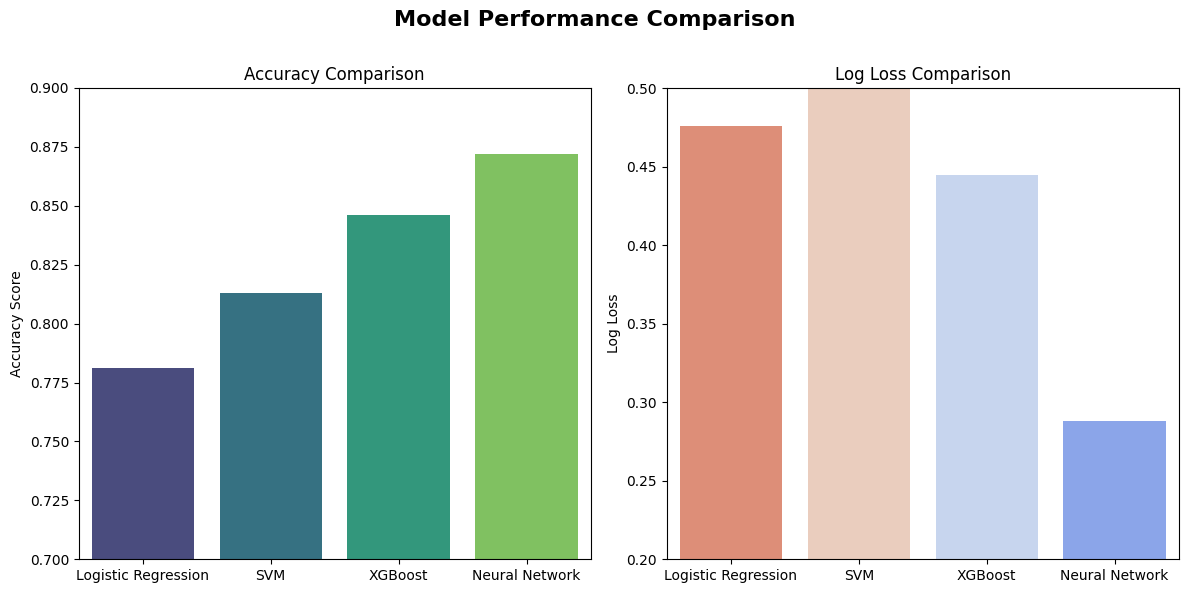

In [76]:
#Define model names
models = ["Logistic Regression", "SVM", "XGBoost", "Neural Network"]

# Accuracy Scores
accuracy_scores = [0.781, 0.813, 0.846, 0.872]

# Log Loss Values
log_loss_values = [0.4755, 0.6327, 0.4448, 0.2883]

# Create a 1x2 grid for plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold")

# Accuracy Comparison
sns.barplot(x=models, y=accuracy_scores, ax=axes[0], palette="viridis")
axes[0].set_title("Accuracy Comparison")
axes[0].set_ylabel("Accuracy Score")
axes[0].set_ylim(0.7, 0.9)

# Log Loss Comparison
sns.barplot(x=models, y=log_loss_values, ax=axes[1], palette="coolwarm_r")
axes[1].set_title("Log Loss Comparison")
axes[1].set_ylabel("Log Loss")
axes[1].set_ylim(0.2, 0.5)

# Show all plots
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title position
plt.show()

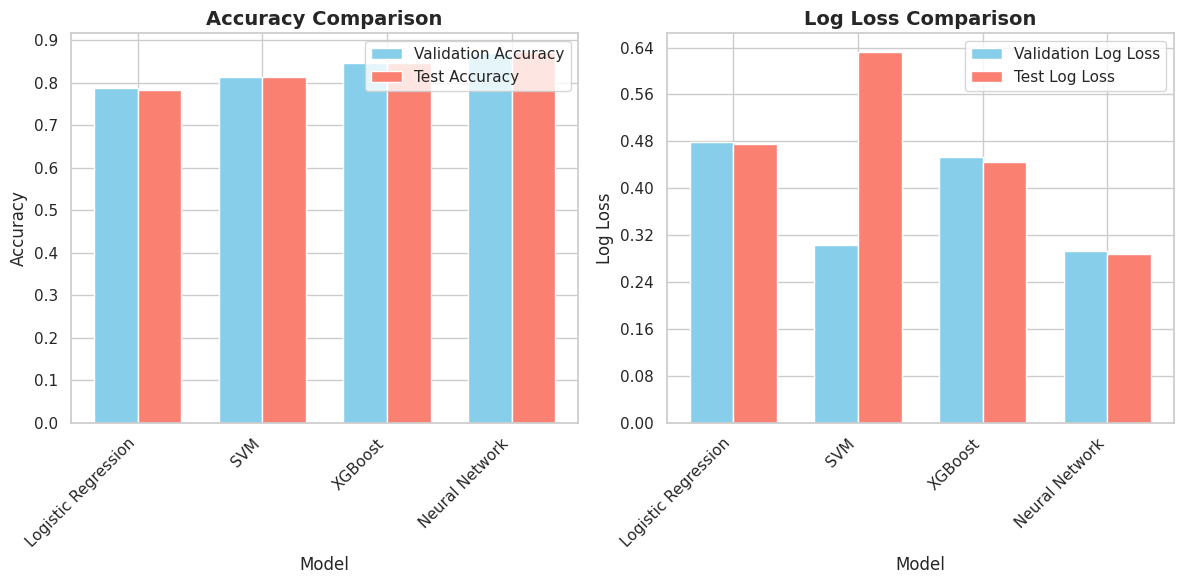

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Create a DataFrame to hold the performance metrics
model_metrics = {
    'Model': ['Logistic Regression', 'SVM', 'XGBoost', 'Neural Network'],
    'Validation Accuracy': [0.7867, 0.8131, 0.8453, 0.8702],
    'Test Accuracy': [0.7814, 0.8138, 0.8463, 0.8721],
    'Validation Log Loss': [0.4782, 0.3027, 0.4538, 0.2931],
    'Test Log Loss': [0.4755, 0.6327, 0.4448, 0.2883]
}

# Convert to a DataFrame
df_metrics = pd.DataFrame(model_metrics)

# Set up the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a more visually appealing table using pandas' styling
table_style = df_metrics.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
    {'selector': 'th', 'props': [('border', '1px solid black'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '8px')]},
])

# Display the styled table
table_style

# Set up the figure for plots
plt.figure(figsize=(12, 6))

# Plot Accuracy (Validation and Test)
plt.subplot(1, 2, 1)
bar_width = 0.35
index = range(len(df_metrics))
plt.bar(index, df_metrics['Validation Accuracy'], bar_width, label='Validation Accuracy', color='skyblue')
plt.bar([i + bar_width for i in index], df_metrics['Test Accuracy'], bar_width, label='Test Accuracy', color='salmon')
plt.title('Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks([i + bar_width / 2 for i in index], df_metrics['Model'], rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

# Plot Log Loss (Validation and Test)
plt.subplot(1, 2, 2)
plt.bar(index, df_metrics['Validation Log Loss'], bar_width, label='Validation Log Loss', color='skyblue')
plt.bar([i + bar_width for i in index], df_metrics['Test Log Loss'], bar_width, label='Test Log Loss', color='salmon')
plt.title('Log Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.xticks([i + bar_width / 2 for i in index], df_metrics['Model'], rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
# # ----------------------------------------------------
# # 1. Temporal Feature Engineering
# # ----------------------------------------------------

# # Cyclical encoding for month (capture seasonal patterns)
# data_1['month_sin'] = np.sin(2 * np.pi * data_1['received_month']/12)
# data_1['month_cos'] = np.cos(2 * np.pi * data_1['received_month']/12)

# # Year bins to capture temporal trends
# data_1['year_bin'] = pd.cut(data_1['received_year'],
#                          bins=[2007, 2010, 2015, 2020, 2024],
#                          labels=['2007-2010', '2011-2015', '2016-2020', '2021-2024'])

In [ ]:
# data_2=data_1.copy()

In [ ]:
# # ----------------------------------------------------
# # 2. Biological Interaction Features
# # ----------------------------------------------------
# # List all animal_classification columns
# animal_cols = [col for col in data_2.columns if 'animal_classification_' in col]

# # List all geographic region columns
# region_cols = [col for col in data_2.columns if 'Geographic Region_' in col]

# # Create all possible animal-region interaction features
# for animal in animal_cols:
#     animal_name = animal.split('_')[-1]  # Extract animal name
#     for region in region_cols:
#         region_name = region.split('_')[-1]  # Extract region name

#         # Create interaction feature
#         interaction_name = f'{animal_name}_in_{region_name}'
#         data_2[interaction_name] = data_2[animal] * data_2[region]

# # =============================================================================
# # Additional Biological Features
# # =============================================================================

# # 1. Create predator-prey interaction proxies
# predator_prey_pairs = [
#     ('fox', 'rodents'),
#     ('raccoon', 'rodents'),
#     ('skunk', 'rodents')
# ]

# for predator, prey in predator_prey_pairs:
#     data_2[f'{predator}_prey_{prey}'] = data_2[f'animal_classification_{predator}'] * data_2[f'animal_classification_{prey}']

# # 2. Create domestic-wild interaction features
# data_2['domestic_wild_interaction'] = (
#     data_2['animal_classification_dog'] +
#     data_2['animal_classification_cat'] +
#     data_2['animal_classification_domestic other']
# ) * (
#     data_2['animal_classification_skunk'] +
#     data_2['animal_classification_raccoon'] +
#     data_2['animal_classification_wild other']
# )

# # 3. Create seasonal risk features for different animals
# seasonal_high_risk = {
#     'skunk': [4, 5, 6, 7],  # Spring/Summer
#     'raccoon': [8, 9, 10],   # Fall
#     'fox': [11, 12, 1]       # Winter
# }

# for animal, months in seasonal_high_risk.items():
#     data_2[f'{animal}_seasonal_risk'] = data_2[f'animal_classification_{animal}'] * data_2['received_month'].isin(months)

In [ ]:
# data_3=data_2.copy()

In [ ]:
# display(data_3.head())

train test validation split seed value 42
standard scaling only for LR, not needed for rest
loss value
add NN
add graphs numberical data trends

